# A Jupyter notebook where BTC data downloaded from Binance is prepped for traning

In [36]:
# Importing relevant libraries for data management and visualization
# ta library used for technichal analysis indicators

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
import pandas_ta as ta
import warnings
warnings.filterwarnings("ignore")

Data was downloaded from https://www.binance.com/en/landing/data
CSV files from sept2019 to nov2020 where used as it represents an acumulating phase according to the 4 year cycle theory.
I belive that from mid 2023 untill november 2024 there will be a similar accumulation phase for BTC so I decided to train the data with this time period.  Binance asks its users to download the historical data via its download links instead of the API so the servers dont get overwhelmed.

In [139]:
# specifying the path to csv files
path = "/home/martin/Downloads"
  
# list of csv files in the path
files = glob.glob(path + "/*.csv")
  
# defining an empty df to store content
btc_df = pd.DataFrame(columns=["date","open","high","low","close","volume","close_time","quote_volume","count","taker_buy_volume",
                         "taker_buy_quote_volume","ignore"])
 
# reading all the csv files in the specified path and appending them to the btc_df
for filename in files:
    df = pd.read_csv(filename, names=["date","open","high","low","close","volume","close_time","quote_volume","count","taker_buy_volume",
                         "taker_buy_quote_volume","ignore"])
    btc_df = pd.concat([btc_df,df])  
btc_df.sort_values(by="date", inplace=True)
btc_df.head()

,date,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1567296000000,9588.74,9608.80,9579.34,9607.85,75.066945,1567296299999,719990.082021,891,42.693944,409497.287252,0
1,1567296300000,9604.57,9615.45,9594.00,9600.55,70.945642,1567296599999,681419.492632,561,18.906562,181685.336981,0
2,1567296600000,9598.48,9615.19,9598.02,9609.30,36.108642,1567296899999,346962.304284,578,21.347931,205124.153678,0
3,1567296900000,9609.31,9625.00,9609.30,9620.00,85.606839,1567297199999,823295.804760,951,42.620899,409907.741723,0
4,1567297200000,9620.00,9623.73,9608.14,9620.23,38.321111,1567297499999,368555.022540,575,15.023955,144511.599644,0


In [140]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131373 entries, 0 to 8627
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    131373 non-null  object 
 1   open                    131373 non-null  float64
 2   high                    131373 non-null  float64
 3   low                     131373 non-null  float64
 4   close                   131373 non-null  float64
 5   volume                  131373 non-null  float64
 6   close_time              131373 non-null  object 
 7   quote_volume            131373 non-null  float64
 8   count                   131373 non-null  object 
 9   taker_buy_volume        131373 non-null  float64
 10  taker_buy_quote_volume  131373 non-null  float64
 11  ignore                  131373 non-null  object 
dtypes: float64(8), object(4)
memory usage: 13.0+ MB


131,373 data points evrey 5m where gathered.  The date is represented in UNIX time withms unit.  Irrelevant data was dropped from the DF

In [141]:
btc_df["date"] = pd.to_datetime(btc_df["date"],unit='ms')
btc_df = btc_df.set_index('date')
btc_df.drop(["close_time","quote_volume","count","taker_buy_volume","taker_buy_quote_volume","ignore"], axis=1, inplace=True)
btc_df.sort_index(inplace=True)


btc_df.to_csv("bitcoin.csv")
btc_df.head()

,open,high,low,close,volume
date,,,,,
2019-09-01 00:00:00,9588.74,9608.80,9579.34,9607.85,75.066945
2019-09-01 00:05:00,9604.57,9615.45,9594.00,9600.55,70.945642
2019-09-01 00:10:00,9598.48,9615.19,9598.02,9609.30,36.108642
2019-09-01 00:15:00,9609.31,9625.00,9609.30,9620.00,85.606839
2019-09-01 00:20:00,9620.00,9623.73,9608.14,9620.23,38.321111


To train the models pandas-ta was used to calculate returns and indicators

In [118]:


RSI_sell_limit = 75
RSI_buy_limit = 30
RSI_length = 10

btc_df['RSI'] = btc_df.ta.rsi(close='close', length=RSI_length)

rsi_conditions = [
    (btc_df['RSI'] > RSI_sell_limit),
    (btc_df['RSI'] <= RSI_sell_limit) & (btc_df['RSI'] > RSI_buy_limit),
    (btc_df['RSI'] <= RSI_buy_limit)  
]
rsi_signals=[-1,0,1]
btc_df["rsi_indicator"] = np.select(rsi_conditions,rsi_signals)

btc_df["log_return"] = ta.log_return(close=btc_df["close"])
btc_df.dropna(inplace=True)


# Function to calculate asset holding
def calculate_asset_holding(signals):
    asset = 'USDT'
    asset_list = [asset]

    for signal in signals:
        if signal == 1:
            asset = 'BTC'
        elif signal == -1:
            asset = 'USDT'
        asset_list.append(asset)

    return asset_list[:-1]  # Remove the last element (only for alignment)

# Create a new column 'Asset' to keep track of the asset
btc_df['asset'] = calculate_asset_holding(btc_df['rsi_indicator'].tolist())


This basic trading strategy uses the relative strenghth index (RSI) that describes if an asset is overbought or oversold.  With the RSI calculated over 10 periods (50min) we add a signal indicator to buy (1), hold (0) or sell (-1).  The limits between the signals are estimated.  Later we will optimize the limits fro better returns.


In [119]:
btc_df.tail(10)

,open,high,low,close,volume,RSI_10,RSI,rsi_indicator,log_return,asset
date,,,,,,,,,,
2020-11-30 23:10:00,19490.96,19495.07,19450.43,19482.68,177.475086,61.750942,61.750942,0,-0.000425,BTC
2020-11-30 23:15:00,19482.68,19550.00,19482.68,19550.00,563.600582,70.803706,70.803706,0,0.003449,BTC
2020-11-30 23:20:00,19550.00,19578.46,19535.88,19557.93,770.028336,71.680961,71.680961,0,0.000406,BTC
2020-11-30 23:25:00,19557.93,19620.90,19551.86,19619.55,462.917263,77.514225,77.514225,-1,0.003146,BTC
2020-11-30 23:30:00,19619.55,19675.00,19619.19,19641.75,722.316915,79.227076,79.227076,-1,0.001131,USDT
2020-11-30 23:35:00,19641.58,19679.67,19594.46,19674.15,431.120626,81.510968,81.510968,-1,0.001648,USDT
2020-11-30 23:40:00,19674.15,19695.46,19629.24,19691.87,360.297399,82.668892,82.668892,-1,0.000900,USDT
2020-11-30 23:45:00,19691.87,19747.05,19670.00,19746.40,586.810308,85.725596,85.725596,-1,0.002765,USDT
2020-11-30 23:50:00,19746.41,19747.03,19625.05,19641.37,472.335209,62.234879,62.234879,0,-0.005333,USDT


In [120]:
num_trades = (btc_df['asset'] != btc_df['asset'].shift(axis=0)).sum(axis=0)
print(f'Number of trades made: {num_trades}')

Number of trades made: 1035


##### Ther is over 243 trades made. The strategy has to account for trading costs in each transaction.

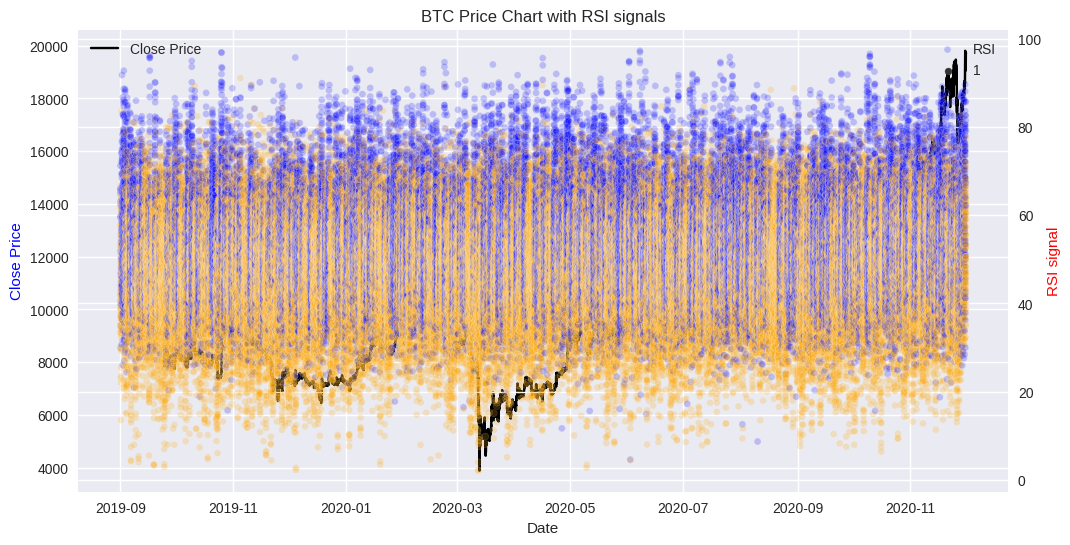

In [123]:
# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a secondary y-axis for RSI
ax2 = ax1.twinx()

# Plot RSI on the secondary y-axis
colors = ['orange' if s == 'BTC' else 'blue' for s in btc_df['asset']]
sns.scatterplot(data=btc_df, x='date', y='RSI', ax=ax2, label='RSI', color=colors, size=1 ,alpha=0.2)

# Plot close prices on the primary y-axis
sns.lineplot(data=btc_df, x='date', y='close', ax=ax1, label='Close Price', color='black')


# Customize the chart
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax2.set_ylabel('RSI signal', color='red')
ax1.set_title('BTC Price Chart with RSI signals')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [124]:
# Define the date range you want to plot
start_date = '2019-11-1'
end_date = '2019-11-5'

# Filter the DataFrame to include only the desired date range
filtered_df = btc_df[(btc_df.index >= start_date) & (btc_df.index <= end_date)]

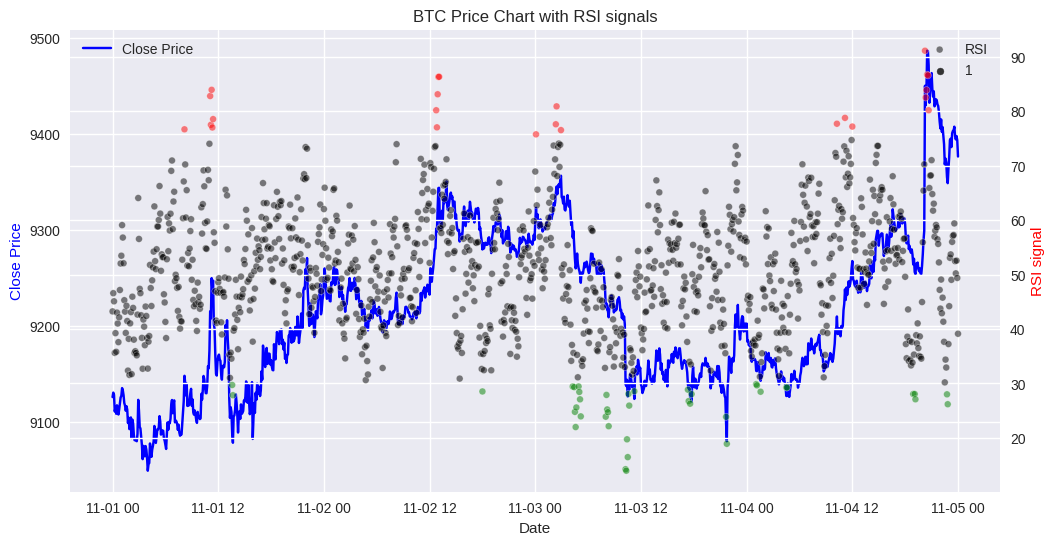

In [125]:
# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a secondary y-axis for RSI
ax2 = ax1.twinx()

# Plot RSI on the secondary y-axis
colors = ['red' if s == -1 else 'green' if s == 1 else 'black' for s in filtered_df['rsi_indicator']]
sns.scatterplot(data=filtered_df, x='date', y='RSI', ax=ax2, label='RSI', color=colors, size=1 ,alpha=0.5)

# Plot close prices on the primary y-axis
sns.lineplot(data=filtered_df, x='date', y='close', ax=ax1, label='Close Price', color='blue')


# Customize the chart
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax2.set_ylabel('RSI signal', color='red')
ax1.set_title('BTC Price Chart with RSI signals')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

The green dots show buy positions and the red dots sell positions.  The graph shows that the RSI strategy can somewhat recognize local bottoms to buy and local tops to sell.

# Backtesting

In [126]:
btc_df['trading'] = np.where(btc_df['asset'] == 'BTC', 1, 0)

btc_df['strategy'] = btc_df['trading'].shift(1) * btc_df['log_return']
btc_df.tail()

,open,high,low,close,volume,RSI_10,RSI,rsi_indicator,log_return,asset,trading,strategy
date,,,,,,,,,,,,
2020-11-30 23:35:00,19641.58,19679.67,19594.46,19674.15,431.120626,81.510968,81.510968,-1,0.001648,USDT,0,0.0
2020-11-30 23:40:00,19674.15,19695.46,19629.24,19691.87,360.297399,82.668892,82.668892,-1,0.000900,USDT,0,0.0
2020-11-30 23:45:00,19691.87,19747.05,19670.00,19746.40,586.810308,85.725596,85.725596,-1,0.002765,USDT,0,0.0
2020-11-30 23:50:00,19746.41,19747.03,19625.05,19641.37,472.335209,62.234879,62.234879,0,-0.005333,USDT,0,-0.0
2020-11-30 23:55:00,19641.37,19700.00,19635.00,19695.87,473.001131,67.387319,67.387319,0,0.002771,USDT,0,0.0


In [127]:
btc_df[["log_return", "strategy"]].sum().apply(np.exp)
btc_df["cstrategy"] = btc_df["strategy"].cumsum().apply(np.exp) 
btc_df["creturns"] = btc_df['log_return'].cumsum().apply(np.exp)
btc_df.tail()

,open,high,low,close,volume,RSI_10,RSI,rsi_indicator,log_return,asset,trading,strategy,cstrategy,creturns
date,,,,,,,,,,,,,,
2020-11-30 23:35:00,19641.58,19679.67,19594.46,19674.15,431.120626,81.510968,81.510968,-1,0.001648,USDT,0,0.0,1.130701,2.044694
2020-11-30 23:40:00,19674.15,19695.46,19629.24,19691.87,360.297399,82.668892,82.668892,-1,0.000900,USDT,0,0.0,1.130701,2.046536
2020-11-30 23:45:00,19691.87,19747.05,19670.00,19746.40,586.810308,85.725596,85.725596,-1,0.002765,USDT,0,0.0,1.130701,2.052203
2020-11-30 23:50:00,19746.41,19747.03,19625.05,19641.37,472.335209,62.234879,62.234879,0,-0.005333,USDT,0,-0.0,1.130701,2.041287
2020-11-30 23:55:00,19641.37,19700.00,19635.00,19695.87,473.001131,67.387319,67.387319,0,0.002771,USDT,0,0.0,1.130701,2.046952


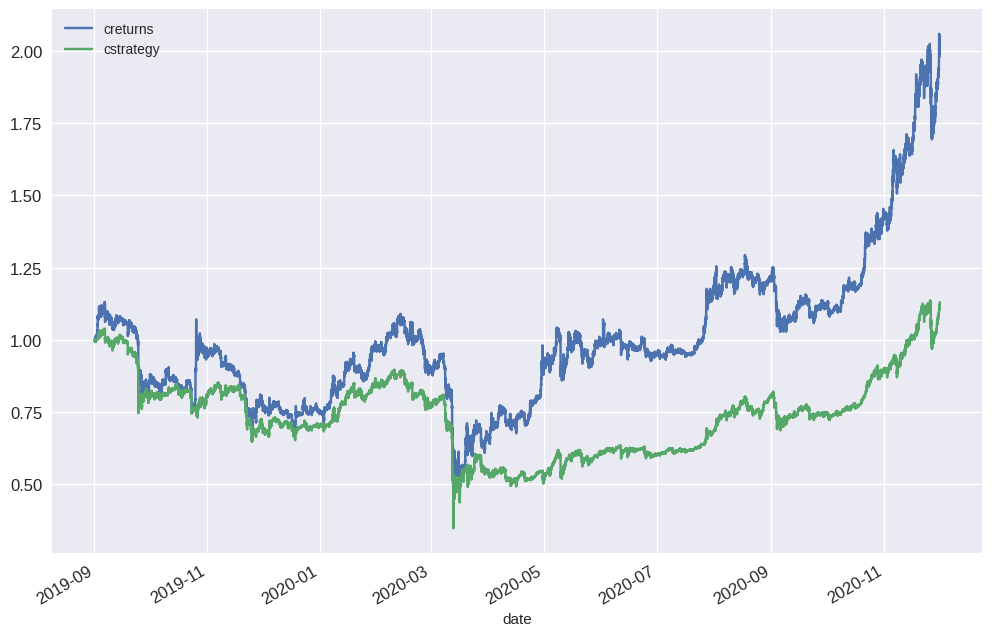

In [128]:
btc_df[["creturns", "cstrategy"]].plot(figsize = (12 , 8), fontsize = 12)
plt.show()

In [129]:
tp_year = 12 * 24 * 365.25 # 5min trading periods per year

In [130]:
ann_mean = btc_df[["log_return", "strategy"]].mean() * tp_year
ann_std = btc_df[["log_return", "strategy"]].std() * np.sqrt(tp_year)
sharpe = (np.exp(ann_mean) - 1) / ann_std
sharpe

log_return    1.045391
strategy      0.170379
dtype: float64

# Trading Costs

In [131]:
btc_df['rsi_indicator'].value_counts()

rsi_indicator
 0    122166
 1      5998
-1      3199
Name: count, dtype: int64

In [132]:
btc_df["trades"] = (btc_df['asset'] != btc_df['asset'].shift(axis=0)).astype(int) # absolute change in position
btc_df.head(25)

,open,high,low,close,volume,RSI_10,RSI,rsi_indicator,log_return,asset,trading,strategy,cstrategy,creturns,trades
date,,,,,,,,,,,,,,,
2019-09-01 00:50:00,9622.05,9630.00,9616.82,9626.23,48.908620,71.301831,71.301831,0,0.000434,USDT,0,NaN,NaN,1.000434,1
2019-09-01 00:55:00,9626.23,9626.23,9613.66,9617.06,29.903434,51.900069,51.900069,0,-0.000953,USDT,0,-0.000000,1.000000,0.999481,0
2019-09-01 01:00:00,9617.06,9621.83,9613.13,9613.76,16.220012,46.807277,46.807277,0,-0.000343,USDT,0,-0.000000,1.000000,0.999138,0
2019-09-01 01:05:00,9613.24,9626.00,9613.24,9623.35,15.442069,59.606009,59.606009,0,0.000997,USDT,0,0.000000,1.000000,1.000135,0
2019-09-01 01:10:00,9623.39,9642.58,9623.29,9630.00,65.166379,65.923323,65.923323,0,0.000691,USDT,0,0.000000,1.000000,1.000826,0
2019-09-01 01:15:00,9630.00,9630.00,9620.41,9629.72,23.499656,65.444492,65.444492,0,-0.000029,USDT,0,-0.000000,1.000000,1.000797,0
2019-09-01 01:20:00,9628.27,9629.70,9625.73,9628.46,15.945346,63.151017,63.151017,0,-0.000131,USDT,0,-0.000000,1.000000,1.000666,0
2019-09-01 01:25:00,9628.46,9633.50,9626.20,9630.07,32.871187,64.897528,64.897528,0,0.000167,USDT,0,0.000000,1.000000,1.000834,0
2019-09-01 01:30:00,9629.28,9631.58,9623.08,9627.40,19.373752,59.684939,59.684939,0,-0.000277,USDT,0,-0.000000,1.000000,1.000556,0


In [133]:
btc_df.trades.value_counts()

trades
0    130328
1      1035
Name: count, dtype: int64

##### over 3400 single trades.  each trade has costs that must be included.

In [134]:
commissions = 0.00075 # reduced Binance commission 0.075%
other = 0.0001 # proportional costs for bid-ask spread & slippage

# total proportional trading costs (negative log return)
ptc = np.log(1 - commissions) + np.log(1 - other)
ptc

-0.0008502863910375247

In [135]:
btc_df["strategy_net"] = btc_df['strategy'] + btc_df['trades'] * ptc # strategy returns net of costs
btc_df["cstrategy_net"] = btc_df.strategy_net.cumsum().apply(np.exp)

In [136]:
btc_df.head(25)

,open,high,low,close,volume,RSI_10,RSI,rsi_indicator,log_return,asset,trading,strategy,cstrategy,creturns,trades,strategy_net,cstrategy_net
date,,,,,,,,,,,,,,,,,
2019-09-01 00:50:00,9622.05,9630.00,9616.82,9626.23,48.908620,71.301831,71.301831,0,0.000434,USDT,0,NaN,NaN,1.000434,1,NaN,NaN
2019-09-01 00:55:00,9626.23,9626.23,9613.66,9617.06,29.903434,51.900069,51.900069,0,-0.000953,USDT,0,-0.000000,1.000000,0.999481,0,-0.000000,1.000000
2019-09-01 01:00:00,9617.06,9621.83,9613.13,9613.76,16.220012,46.807277,46.807277,0,-0.000343,USDT,0,-0.000000,1.000000,0.999138,0,-0.000000,1.000000
2019-09-01 01:05:00,9613.24,9626.00,9613.24,9623.35,15.442069,59.606009,59.606009,0,0.000997,USDT,0,0.000000,1.000000,1.000135,0,0.000000,1.000000
2019-09-01 01:10:00,9623.39,9642.58,9623.29,9630.00,65.166379,65.923323,65.923323,0,0.000691,USDT,0,0.000000,1.000000,1.000826,0,0.000000,1.000000
2019-09-01 01:15:00,9630.00,9630.00,9620.41,9629.72,23.499656,65.444492,65.444492,0,-0.000029,USDT,0,-0.000000,1.000000,1.000797,0,-0.000000,1.000000
2019-09-01 01:20:00,9628.27,9629.70,9625.73,9628.46,15.945346,63.151017,63.151017,0,-0.000131,USDT,0,-0.000000,1.000000,1.000666,0,-0.000000,1.000000
2019-09-01 01:25:00,9628.46,9633.50,9626.20,9630.07,32.871187,64.897528,64.897528,0,0.000167,USDT,0,0.000000,1.000000,1.000834,0,0.000000,1.000000
2019-09-01 01:30:00,9629.28,9631.58,9623.08,9627.40,19.373752,59.684939,59.684939,0,-0.000277,USDT,0,-0.000000,1.000000,1.000556,0,-0.000000,1.000000


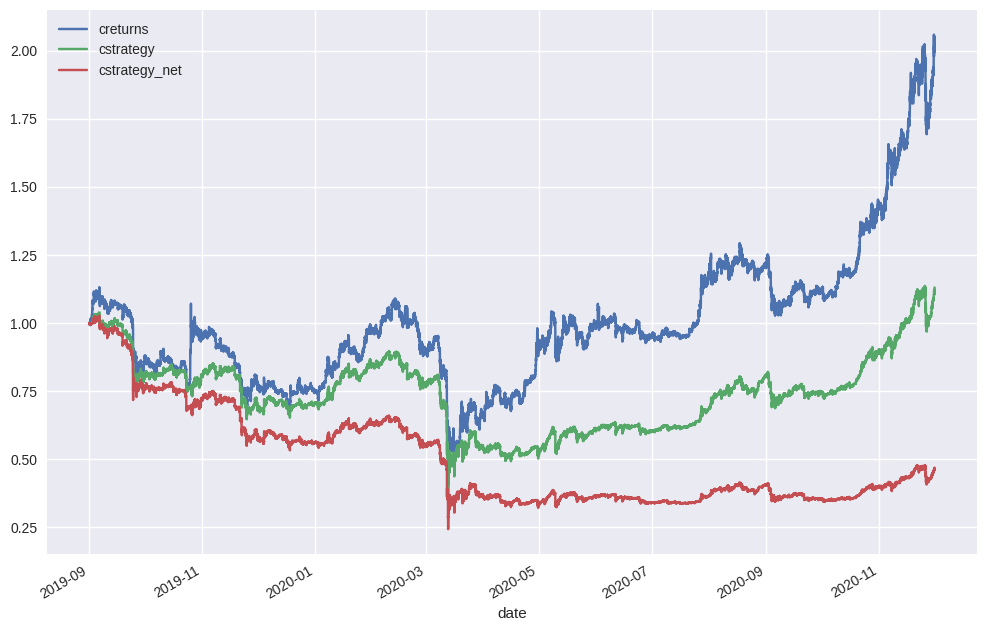

In [137]:
btc_df[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

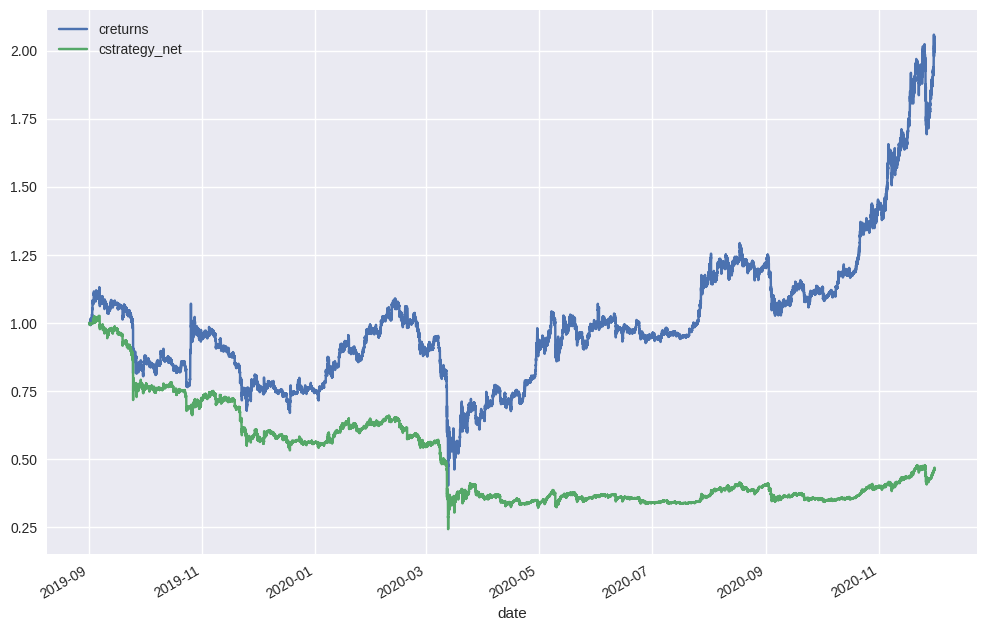

In [138]:
btc_df[["creturns", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

# Optimization
The strategy has to be optimized for higher returns.  To do this we need to run back tests with different variables.  I will be done on a different notebook.